# Customer Review Analysis for Complaint Categorization and Improvement Insights

### ✅ Problem Statement

Customer reviews contain valuable insights for product improvement.
However, due to the overwhelming volume of reviews, manual analysis is difficult, time-consuming, and often inconsistent.

Companies struggle to identify and act on recurring customer complaints, which leads to missed opportunities for improving product quality and customer satisfaction.

<br>

### 💡 Proposed Solution

This project developed a system that automatically classifies customer reviews by sentiment (positive, negative, improvement) using a Large Language Model (LLM), and then generates actionable suggestions for improvement based on negative and improvement feedback.

The pipeline also includes a feedback category tagging system (e.g., quality, delivery, price), allowing businesses to monitor which areas receive the most criticism.

For example:

“The material is too thin” → “Consider improving the product fabric quality.”

The results are structured in a way that allows for real-time feedback monitoring, making it easier for teams to prioritize product enhancements and customer support initiatives.

<br>

### 🧩 Key Features
	•	LLM-based sentiment classification with confidence score
	•	Automated extraction of reasoning behind sentiment
	•	Actionable feedback generation from negative and improvement reviews
	•	Feedback category labeling for targeted analysis
	•	Visualization-ready data output for dashboard integration

Table of Contents: 
- About the dataset
- Importing Data
- EDA & Preprocessing
- EDA via Visualizations
- Key Analyses
- Insight & Suggestion
- References
- Assumptions

## 📊 Dataset Description
#### Source: amazon_reviews.csv from Kaggle
#### Size: Approximately 10,000 reviews
Raw Format:
- **label** (label_0, label_1)
- **review** (raw text)

After preprocessing using a custom LLM pipeline, the dataset was enriched into the following structure:
- **id** : Unique identifier
- **original_review** : Raw customer review
- **reason** : Reasoning behind the sentiment classification (generated by LLM)
- **feedback** : Structured feedback suggestion
- **sentiment** : LLM-based sentiment label: Positive, Negative, Improvement
- **confidence** : LLM’s confidence score for sentiment classification
- **category** : Manually or semi-automatically tagged feedback category (e.g., Content, Quality, Design, Information, Other)


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter 
from wordcloud import WordCloud, STOPWORDS# for word sentiment
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS # preprocess for words
import spacy # for nlp

In [2]:
df_llm = pd.read_csv("results_with_feedback.csv") # preprocessing data using LLM
df_reviews = pd.read_csv("balanced_reviews_fixed.csv") # original_data (amazon_reviews)

In [3]:
df_llm.tail()

,id,sentiment,reason,confidence,feedback
9975,9995,positive,The review praises the movie and considers it ...,0.90,NaN
9976,9996,negative,The review expresses extreme dissatisfaction w...,0.95,Redesign the 3-blade razor to be narrower and ...
9977,9997,negative,The review describes the product as not workin...,0.90,Improve the quality control of the weighted di...
9978,9998,negative,The review expresses disappointment with the s...,0.80,Explore alternative storylines for Shane's rel...
9979,9999,negative,The review expresses strong dislike for the pr...,0.98,Develop more interactive and engaging features...


In [4]:
df_reviews.head()

,id,review
0,0,Vintage Classics Edition--proceed with caution...
1,1,Very nice set especially for the money: Bought...
2,2,Profound: I bought this CD blindly - just beca...
3,3,Great!: When I was a little kid. I would try t...
4,4,After a few months- broken: This charger worke...


- LLM responses only contain the following fields, and the original review is not included.
- Therefore, to perform EDA, visualization, or review inspection, it’s essential to reattach the original review based on the id field.

In [5]:
df_merged = pd.merge(df_llm, df_reviews, on="id", how="left")
df_merged.rename(columns={"review": "original_review"}, inplace=True)

In [6]:
print(df_reviews["id"].duplicated().sum())
print(df_llm["id"].duplicated().sum())

0
0


## Exploratory Data Analysis (EDA)

In [7]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9980 entries, 0 to 9979
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               9980 non-null   int64  
 1   sentiment        9980 non-null   object 
 2   reason           9980 non-null   object 
 3   confidence       9980 non-null   float64
 4   feedback         5028 non-null   object 
 5   original_review  9980 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 545.8+ KB


In [8]:
df_merged.shape

(9980, 6)

10,000 - 58(20 parsing error + 38 missing) = 9,942<br>
Approximately **99.4%** of the reviews received successful responses from the LLM.<br>
A small number of missing or erroneous cases (58 in total) were either corrected through excluded from the final analysis.

In [9]:
print(df_merged.duplicated().sum())
print(df_merged.isnull().sum())

0
id                    0
sentiment             0
reason                0
confidence            0
feedback           4952
original_review       0
dtype: int64


In [10]:
df_merged[df_merged['sentiment'] == 'positive']['id']

1          1
2          2
3          3
7          7
15        15
        ... 
9968    9988
9969    9989
9973    9993
9974    9994
9975    9995
Name: id, Length: 4647, dtype: int64

In [11]:
for i in df_merged.columns:
    print(f"{i}'s unique value amount : {df_merged[i].nunique()}\n")


id's unique value amount : 9980

sentiment's unique value amount : 3

reason's unique value amount : 9928

confidence's unique value amount : 20

feedback's unique value amount : 4962

original_review's unique value amount : 9980



### 1. sentiment analysis

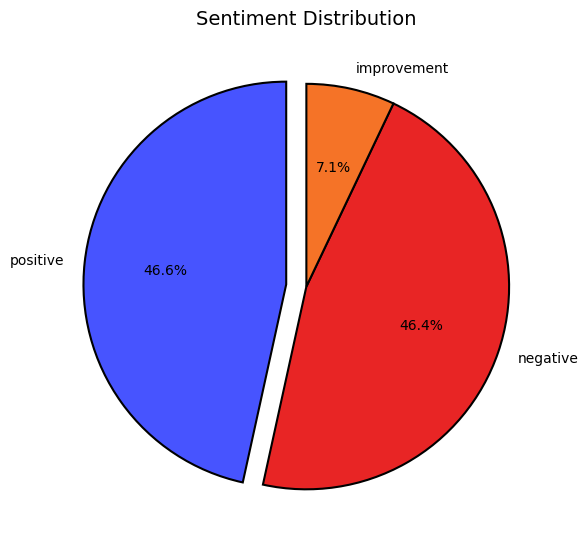

In [12]:
colors = ['#4754ff', '#e82525', '#f57327']  # positive, negative, improvement
sentiment_counts = df_merged['sentiment'].value_counts(normalize=True)
labels = sentiment_counts.index
sizes = sentiment_counts.values

# to emphasize improvement and negative 
explode = [0.0 if label != 'positive' else 0.1 for label in labels]

# pie
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(
    sizes,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    explode=explode,
    startangle=90,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5}
)

plt.title("Sentiment Distribution", fontsize=14)
plt.tight_layout()
plt.show()

The products that is needed to develop are **53.5%** of all.
<br>
I would focus on negative and improvement reviews more.

### 2. Word Cloud by sentiment

In [13]:
n_review = WordCloud().generate(" ".join(df_merged[df_merged['sentiment'] == 'negative']['original_review']))
i_review = WordCloud().generate(" ".join(df_merged[df_merged['sentiment'] == 'improvement']['original_review']))
p_review = WordCloud().generate(" ".join(df_merged[df_merged['sentiment'] == 'positive']['original_review']))

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

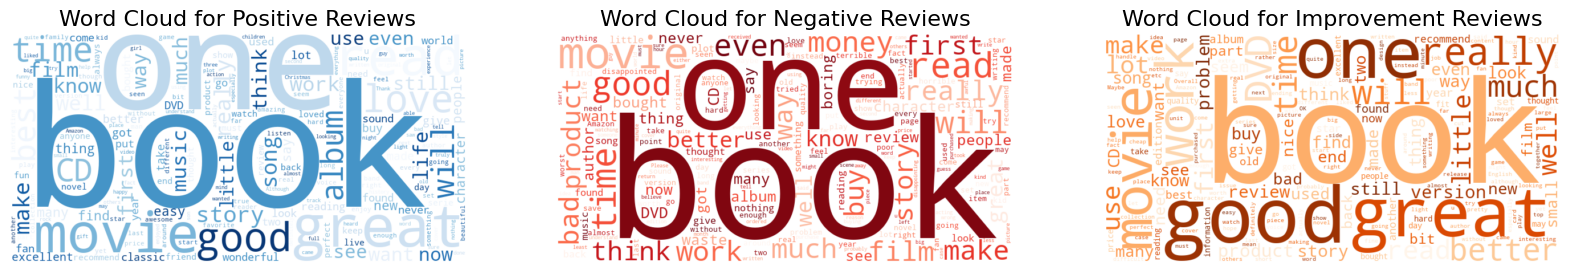

In [14]:
# visualization
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

for ax, sentiment, color in zip(
    axes, 
    ["positive", "negative", "improvement"], 
    ["Blues", "Reds", "Oranges"]
):
    # reviews by sentiment
    text = " ".join(df_merged[df_merged["sentiment"] == sentiment]["original_review"].dropna())
    
    # create word cloud
    wordcloud = WordCloud(
        width=800, height=400, 
        background_color='white', 
        colormap=color
    ).generate(text)
    
    # visualize
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    ax.set_title(f"Word Cloud for {sentiment.capitalize()} Reviews", fontsize=16)

plt.tight_layout

### Key insights from original reviews
#### Positive
- Customers express high satisfaction with the content itself (books, movies, albums).
- Emotionally positive words like “love”, “good”, and “best” appear frequently, indicating strong approval.
- Many reviews suggest a clear intent to recommend the product.
#### Negative
- Most negative feedback centers around disappointment in **content quality** and post-purchase regret.
- Strong negative words like “waste”, “boring”, and “terrible” reflect customer **frustration**.
- Frequent use of terms like “money” and “buy” suggests **dissatisfaction with value for money**.
#### Improvement
- These reviews are generally constructive, mixing positive aspects with requests for improvement.
- Indicates that while customers may be somewhat satisfied, they are expecting more.

### 3. Grouping Feedback into Categories

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

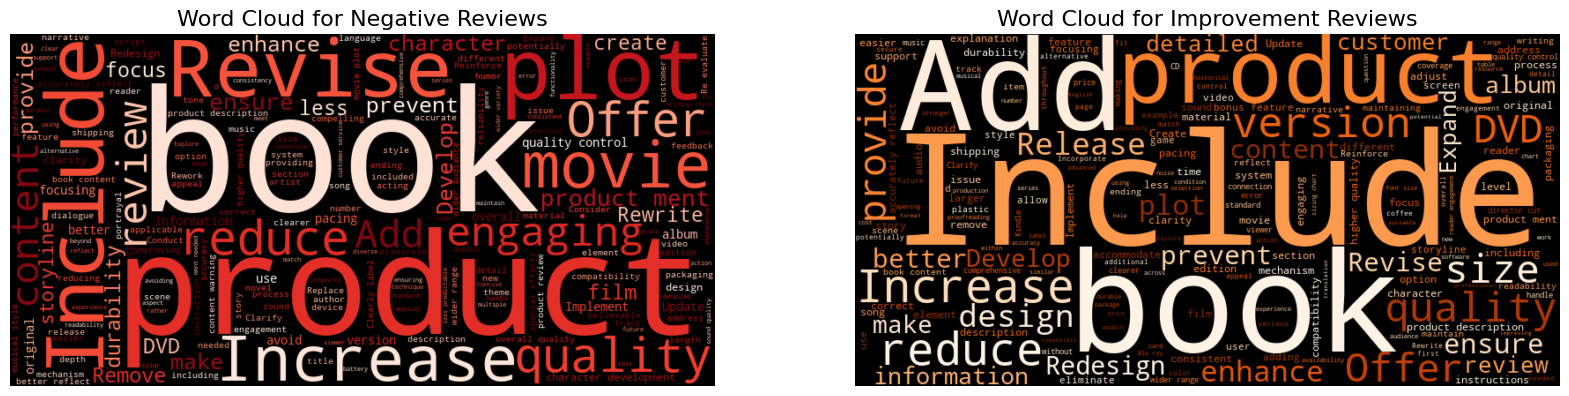

In [15]:
# visualization
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

for ax, sentiment, color in zip(
    axes, 
    ["negative", "improvement"], 
    ["Reds", "Oranges"]
):
    # reviews by sentiment
    text = " ".join(df_merged[df_merged["sentiment"] == sentiment]["feedback"].dropna().str.replace("improve", "", case=False))
    
    # create word cloud
    wordcloud = WordCloud(
        width=800, height=400, 
        background_color='black', 
        colormap=color
    ).generate(text)
    
    # visualize
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    ax.set_title(f"Word Cloud for {sentiment.capitalize()} Reviews", fontsize=16)

plt.tight_layout

In [16]:
df_feedback = df_merged[((df_merged["sentiment"] == "negative") | (df_merged["sentiment"] == "improvement")) & (df_merged["feedback"].notna())]

brought only negative and improvement reviews and join with **category of feedback**

In [17]:
df_feedback.head()

,id,sentiment,reason,confidence,feedback,original_review
60,60,negative,The review expresses strong dissatisfaction wi...,0.90,Offer a refund or exchange policy for opened m...,Don't Let the Smooth Taste Fool You&#65533;: I...
61,61,improvement,The review acknowledges some positive aspects ...,0.85,Improve the noise-canceling feature to elimina...,"not bad, but cheap: got these headphones as a ..."
66,66,negative,The review expresses extreme dissatisfaction w...,0.95,"Revise the plot, improve the acting and zombie...",No.: This movie makes no sense.The title chara...
67,67,negative,"The review expresses strong dissatisfaction, c...",0.90,Organize the book by sport and update the info...,Not Worth the Money - Skip It!: This book is a...
68,68,negative,The review expresses disappointment with the p...,0.92,Improve the earpiece locking mechanism to prev...,Don't waste your money: They look cheep and fe...


In [18]:
df_cat = pd.read_csv("categorized_feedback.csv")
df_feedback = pd.merge(df_feedback, df_cat, on="id", how="left")
df_feedback.head()

,id,sentiment,reason,confidence,feedback,original_review,category
0,60,negative,The review expresses strong dissatisfaction wi...,0.90,Offer a refund or exchange policy for opened m...,Don't Let the Smooth Taste Fool You&#65533;: I...,Service
1,61,improvement,The review acknowledges some positive aspects ...,0.85,Improve the noise-canceling feature to elimina...,"not bad, but cheap: got these headphones as a ...",Quality
2,66,negative,The review expresses extreme dissatisfaction w...,0.95,"Revise the plot, improve the acting and zombie...",No.: This movie makes no sense.The title chara...,Other
3,67,negative,"The review expresses strong dissatisfaction, c...",0.90,Organize the book by sport and update the info...,Not Worth the Money - Skip It!: This book is a...,Other
4,68,negative,The review expresses disappointment with the p...,0.92,Improve the earpiece locking mechanism to prev...,Don't waste your money: They look cheep and fe...,Design


In [19]:
df_others = df_feedback[df_feedback["category"] == "Other"].copy()

def subcategorize_other(feedback):
    feedback = feedback.lower()
    if any(keyword in feedback for keyword in ["movie", "film", "cinema", "actor", "scene", "script", "cd", "music", "sing", "singer", "song"]):
        return "Entertainment Quality"
    elif any(keyword in feedback for keyword in ["book", "chapter", "story", "author"]):
        return "Book Content"
    elif any(keyword in feedback for keyword in ["kindle", "review requirement", "platform"]):
        return "Platform Issue"
    elif any(keyword in feedback for keyword in ["no suggestion", "nothing", "none"]):
        return "No Suggestion"
    elif any(keyword in feedback for keyword in ["wrong product", "different item"]):
        return "Confused Product"
    elif any(keyword in feedback for keyword in ["info", "information"]):
        return "Service"
    else:
        return "Other-Unclassified"

df_others["sub_category"] = df_others["feedback"].apply(subcategorize_other)

In [20]:
df_others['sub_category'].value_counts()

Entertainment Quality    140
Other-Unclassified       116
Book Content              60
Service                    6
Platform Issue             1
Name: sub_category, dtype: int64

In [21]:
df_feedback.loc[df_feedback["category"] == "Other", "category"] = df_others["sub_category"].values

In [22]:
df_feedback['category'].value_counts()

Design                   1135
Quality                   879
Entertainment Quality     140
Other-Unclassified        116
Service                    67
Book Content               60
Shipping                   59
Price                      38
Compatibility               3
Marketing                   2
Platform Issue              1
Name: category, dtype: int64

Since a large portion of the feedback was categorized as “Other,” I decided to further break it down into more specific subcategories.

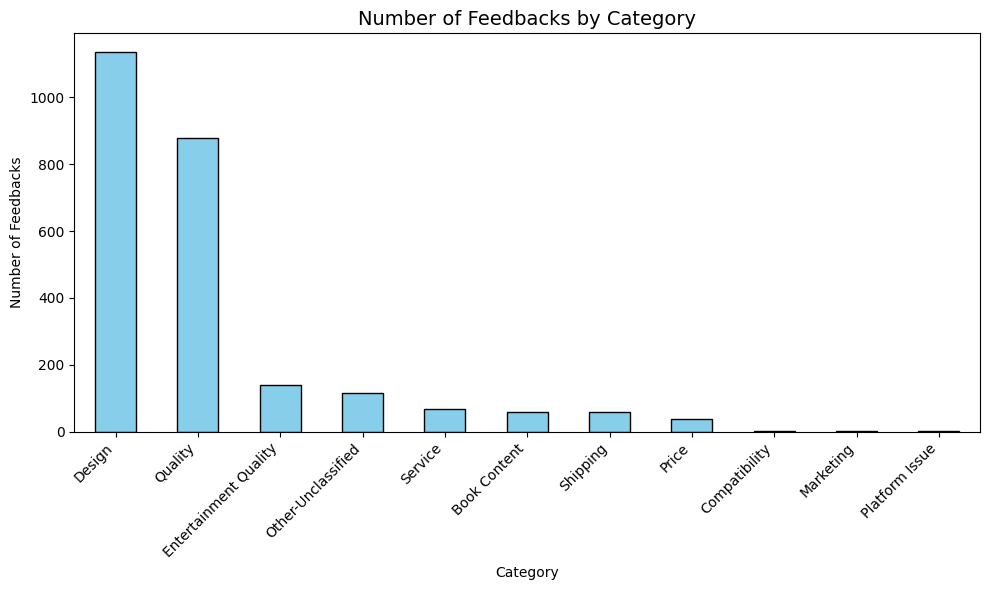

In [23]:
category_counts = df_feedback['category'].value_counts()

plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Number of Feedbacks by Category', fontsize=14)
plt.xlabel('Category')
plt.ylabel('Number of Feedbacks')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

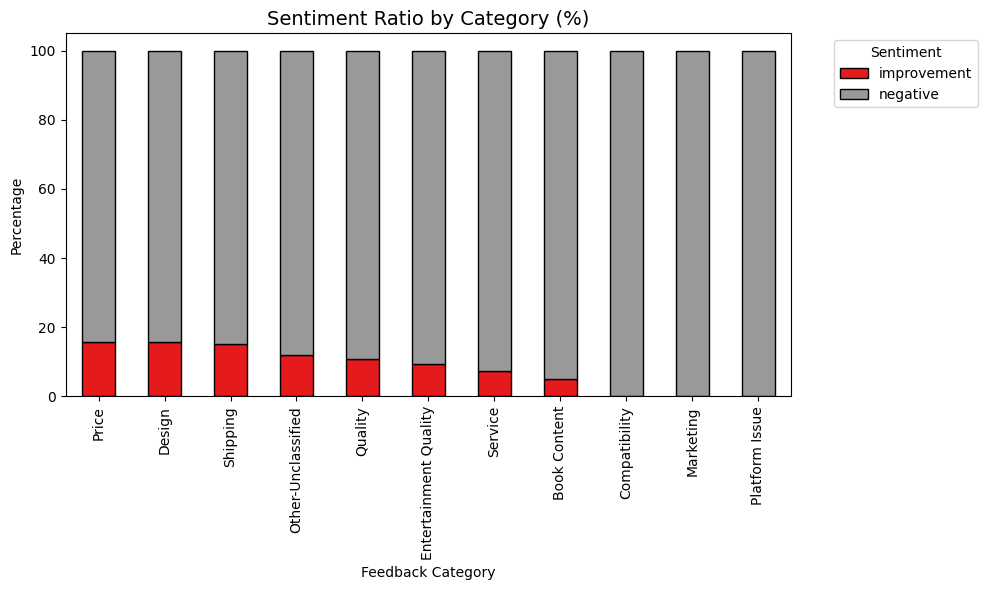

In [24]:
# for ratio of sentiment by cateogory
sentiment_counts = pd.crosstab(df_feedback['category'], df_feedback['sentiment'])
# ratio
sentiment_percent = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0) * 100

sorted_idx = sentiment_percent.sort_values(by='negative', ascending=True).index
sentiment_percent = sentiment_percent.loc[sorted_idx]

# stack
ax = sentiment_percent.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    colormap='Set1',
    edgecolor='black'
)

plt.title('Sentiment Ratio by Category (%)', fontsize=14)
plt.xlabel('Feedback Category')
plt.ylabel('Percentage')
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Number of Feedbacks and Sentiment Ratio by Category 
### Summary & Recommendations

- **Design and Quality** received the highest volume of feedback, indicating key areas for improvement.
- While most categories showed overwhelmingly negative sentiment, categories like **Price and Shipping** included **improvement-oriented feedback**, making them **suitable for quick wins through UX/UI or policy adjustments**.
- A significant portion of feedback was initially labeled as “Other,” which was later refined into more specific subcategories.
- It’s recommended to **prioritize improvements in Design and Quality**, enhance the feedback categorization system, and address severe issues found in **Platform and Compatibility areas**.

### 4. direction of solutions : the most common words in feedback by top categories

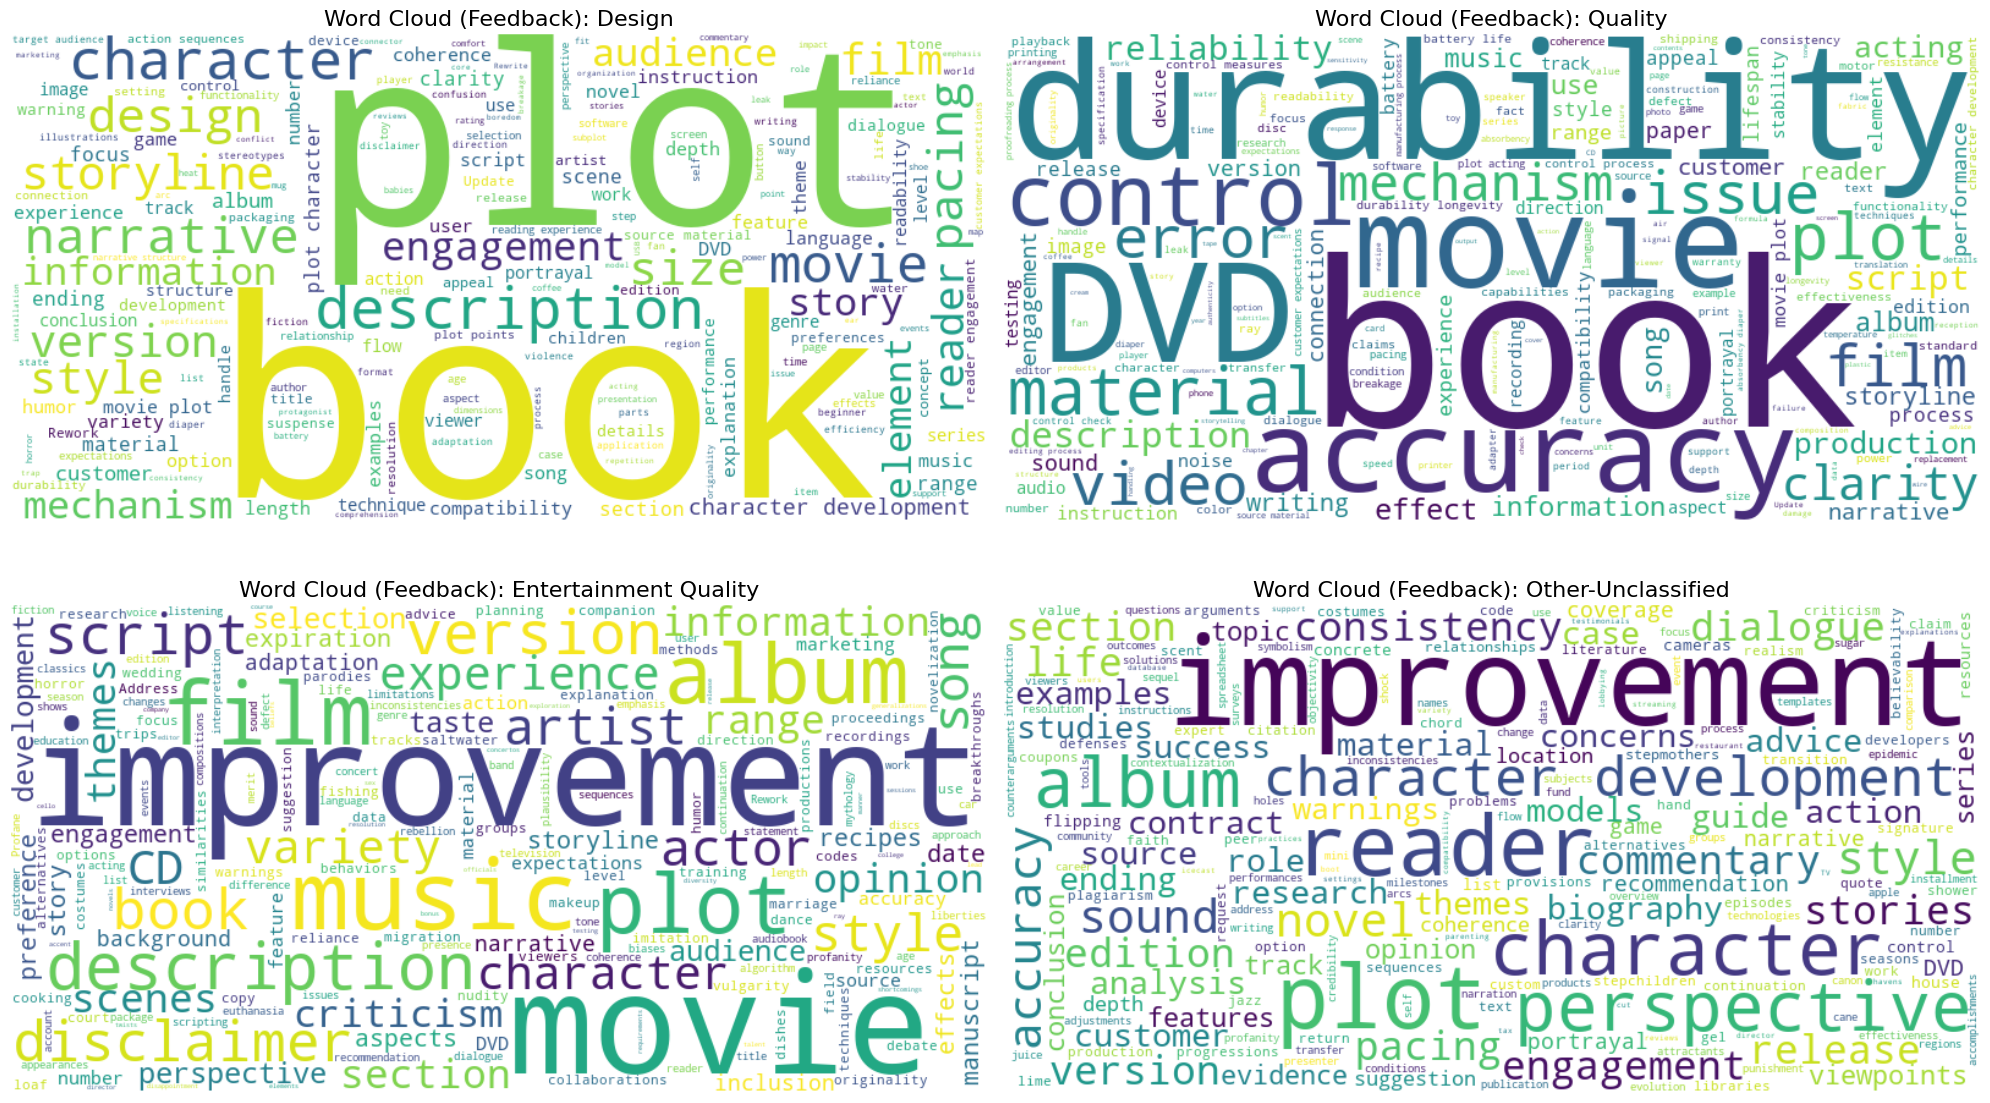

In [25]:
# create object for english nlp
nlp = spacy.load("en_core_web_sm")

custom_stopwords = list(ENGLISH_STOP_WORDS.union({
    'product', 'review', 'improve', 'provide', 'include',
    'content', 'overall', 'quality', 'feedback', 'increase'
}))

def extract_nouns(text):
    doc = nlp(text)
    return " ".join([x.text for x in doc if x.pos_ == "NOUN"])


# top 4 of categories
top_cat = df_feedback['category'].value_counts().nlargest(4).index.tolist()

# the most common words of feedback by cateogry
category_feedback = {
    cat: " ".join(
        df_feedback[df_feedback['category'] == cat]['feedback']
        .dropna().apply(extract_nouns)
    )for cat in top_cat}


# visualization
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = axes.flatten()

for i, cat in enumerate(top_cat):
    text = category_feedback[cat]
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        stopwords=custom_stopwords
    ).generate(text)
    
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f"Word Cloud (Feedback): {cat}", fontsize=16)

plt.tight_layout()
plt.show()

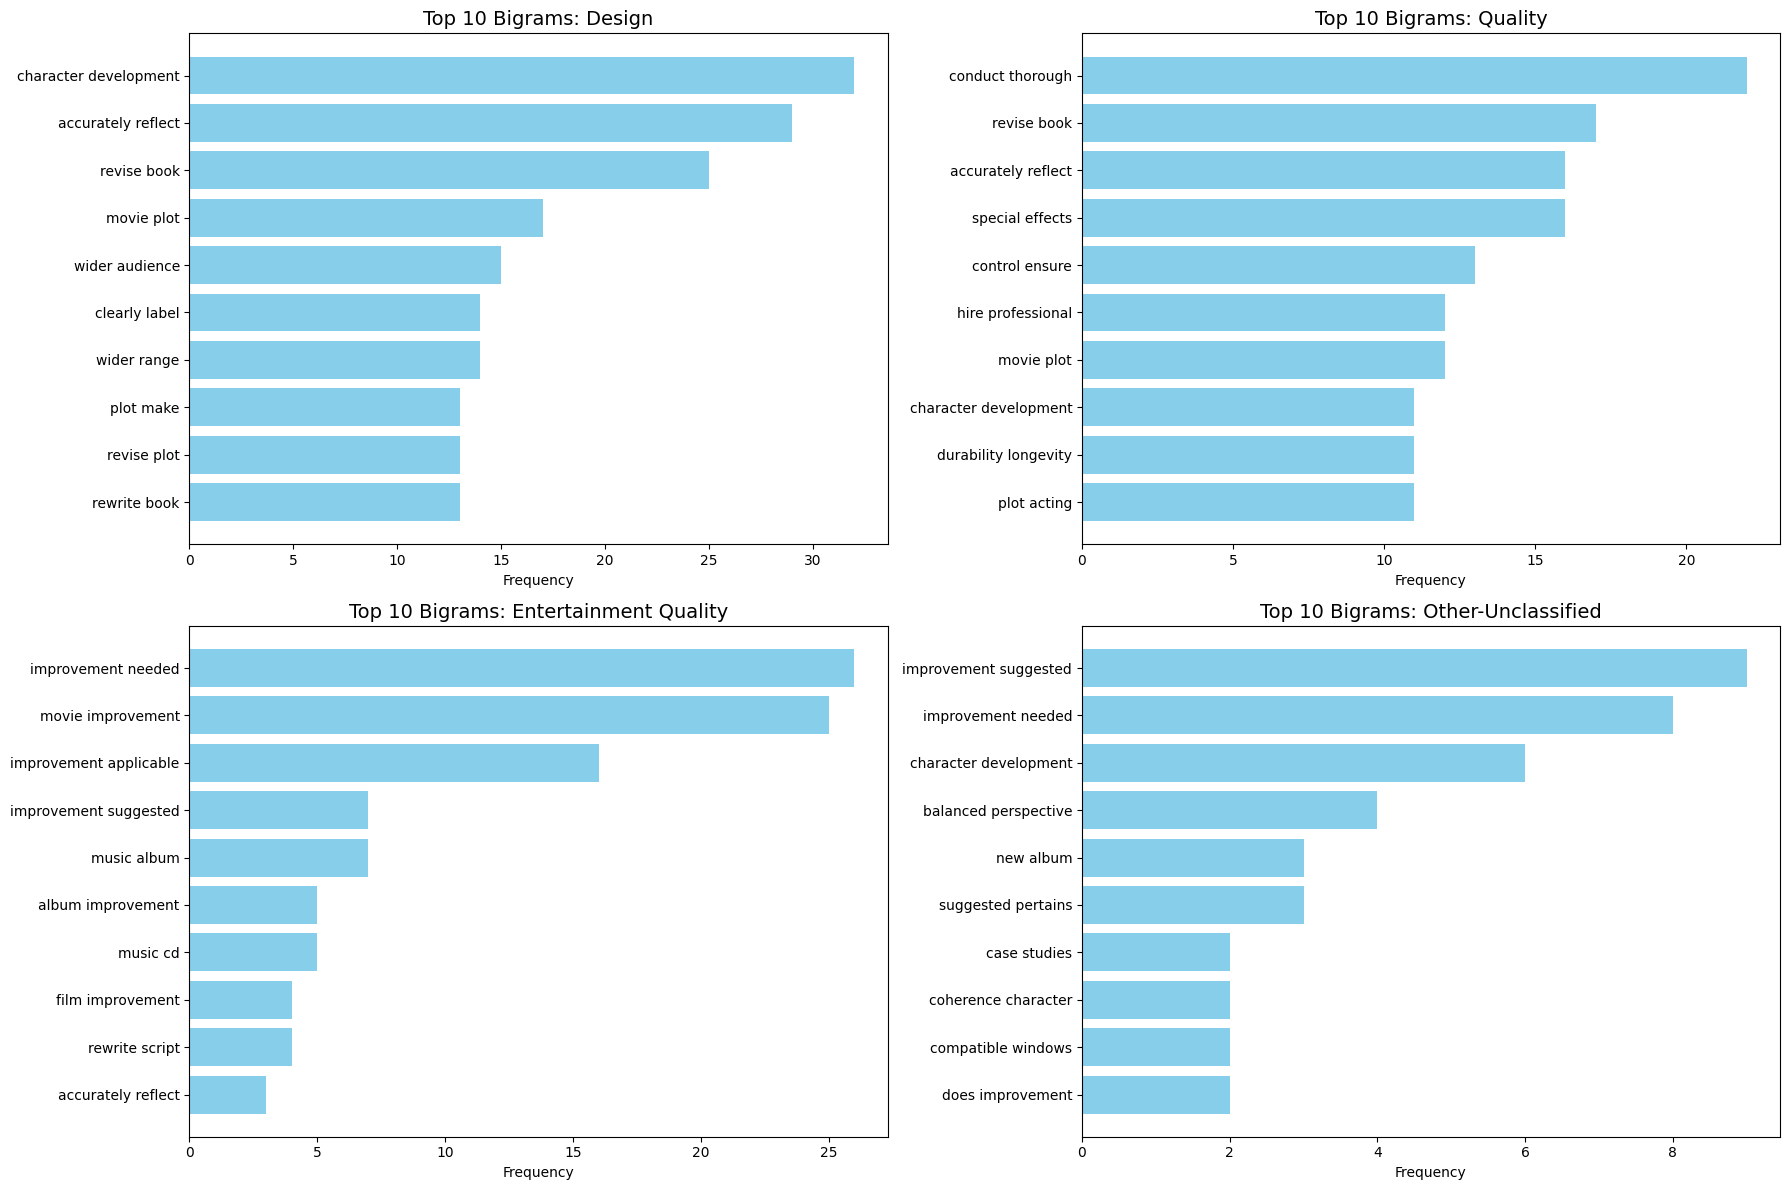

In [26]:
# bigram(2-gram) : word pairs from text

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

for i, cat in enumerate(top_cat):
    # words by categories
    texts = df_feedback[df_feedback['category'] == cat]['feedback'].dropna().tolist()

    # set 2 gram
    vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words=custom_stopwords) # stop words should be list
    X = vectorizer.fit_transform(texts)

    # extract 2 gram and frequency
    bigrams = zip(vectorizer.get_feature_names_out(), X.sum(axis=0).flat)
    top_bigrams = sorted(bigrams, key=lambda x: x[1], reverse=True)[:10]

    if top_bigrams:
        phrases, freqs = zip(*top_bigrams)
        axes[i].barh(phrases[::-1], freqs[::-1], color='skyblue')
        axes[i].set_title(f"Top 10 Bigrams: {cat}", fontsize=14)
        axes[i].set_xlabel("Frequency")

plt.tight_layout()
plt.show()

### Observations by Feedback Category (Top 4)

1. **Design**
**Top Keywords** : plot, character, description, storyline, style
**Top Bigrams** : character development, accurately reflect, revise book, movie plot, rewrite book, wider audience

**Suggested Direction** :
- There is a strong demand for improving story flow and character development.
- The phrase “accurately reflect” implies a mismatch between descriptions and actual content.
- “Wider audience” suggests a need to expand the target readership or diversify the storytelling style.
ㅇ
**Recommendations**:
- Redesign content with improved plot compression/expansion and deeper character depiction.
- Introduce a structured script review process involving writers or editors.
- Conduct A/B testing for different reader segments (e.g., young adults vs. general audience).

2. **Quality**
**Top Keywords** : durability, control, accuracy, material, issue

**Top Bigrams** : conduct thorough, revise book, control ensure, durability longevity, hire professional, special effects

**Suggested Direction** :
- Issues related to durability and accuracy are frequently mentioned.
- Terms like “conduct thorough” and “hire professional” reflect a lack of trust in product quality.
- “Special effects” indicates unmet expectations in functionality or visual quality.

**Recommendations**:
- Integrate professional quality review in the early product planning stage.
- Strengthen testing processes for functionality and precision.
- If the product includes visual or media elements, ensure third-party quality checks.

3. **Entertainment Quality**

**Top Keywords** : improvement, script, dialogue, actor, film, music
**Top Bigrams** : improvement needed, movie improvement, rewrite script, film improvement, music cd, album improvement

**Suggested Direction** :
- Frequent complaints about “rewrite script” and “dialogue” indicate low directing/writing quality.
- Terms like “music CD” and “album improvement” suggest issues with audio quality or arrangement.

**Recommendations**:
- Add dedicated review rounds for script and direction.
- Improve audio quality by collaborating with external sound editing professionals.
- Consider producing a Director’s Cut or enhanced edition based on user feedback.

4. **Other-Unclassified**

**Top Keywords** : improvement, perspective, reader, recommendation, coverage
**Top Bigrams** : improvement suggested, character development, balanced perspective, case studies, coherence character
**Suggested Direction** :
- Mentions of “balanced perspective”, “recommendation”, and “reader” suggest concerns over bias or lack of objectivity.
- “Case studies” highlights the need for more concrete examples.

**Recommendations** :
- Emphasize neutrality and bias review when creating content.
- Include case-based explanations for informative or academic material.
- Refine recommendation algorithms to better match user interests and content context.

### 5. confidence score analysis

In [27]:
df_merged['confidence'].value_counts().sort_index()

0.50       1
0.60       4
0.65       2
0.70     122
0.75     411
0.78      12
0.80    1252
0.82       1
0.85    1269
0.87       1
0.88     448
0.89       4
0.90    2254
0.92    1315
0.93       4
0.95    2006
0.96       7
0.97      93
0.98     758
0.99      16
Name: confidence, dtype: int64

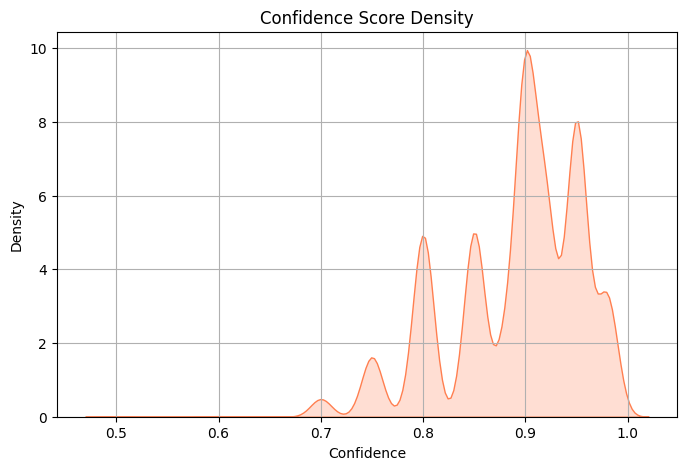

In [28]:
import seaborn as sns

plt.figure(figsize=(8,5))
sns.kdeplot(df_merged['confidence'], fill=True, color='coral')
plt.title("Confidence Score Density")
plt.xlabel("Confidence")
plt.ylabel("Density")
plt.grid(True)
plt.show()

In [29]:
# confidence < 0.75, original_review, reason and sentiment
low_conf_df = df_merged[df_merged['confidence'] < 0.75][['original_review', 'reason', 'sentiment']]
# full content
pd.set_option('display.max_colwidth', None)
low_conf_df.tail(10)

,original_review,reason,sentiment
9331,Dad is in Trouble: This movie is about two twins who look alike and they are on there own soccer team.They switch teams without their mom nowing.,"The review provides a plot summary without expressing an opinion, but the lack of positive or negative sentiment leans towards negative.",negative
9400,"Hot Stuff, Ridiculous Price: The lives of the dysfunctional Fisher family, their friends and co-workers, makes for a highly entertaining black comedy.I have the first two seasons on tape, which is good, because the price for the first season DVD is beyond ridiculous for 13 eps and the paltry few extras that HBO has deigned to give us.The four-star rating is solely for the quality of the series - *not* the package itself....",The review praises the quality of the TV series but criticizes the price of the DVD.,positive
9423,"Where to purchase this book (and PDF) online...: This book (under the name ""MMURTL V1.0"") can be found on Sensory Publishing's website:http://www.sensorypublishing.com/mmurtl.htmlYou can purchase a PDF of the book (and the source of the OS itself), or pay extra for a printed copy in addition to the PDF. (My original review was truncated before the URL for some reason.)",The review provides helpful information on where to purchase the book but is not a review of the book itself.,improvement
9456,"Hmmm...: I was so glad to see that this cd had all new songs on it except for ""The Year the Summer Ended in June"", but after listening to this album over and over I find myself falling into the music rather than listening to it. To me, the album started to become background music instead of saying to my friends ""Hey, check this band out."" The musicianship is awesome mixed with plenty of techy riffs and pounding blasts of the kick drum and I like the vocals much better than their previous release, but that is due to production this time around (produced by Devin Townshend of Strapping Young Lad), I still find myself leaning towards the EP for more playability and a more raw sound. However, this is definately an album worth owning and listening to if you like metalcore.","Despite some minor criticisms about the album's background music quality, the overall sentiment is positive, praising the musicianship and production.",positive
9595,So So Movie: This movie had decent ratings on imdb. I wanted to see an action flick with a mix of thriller. This movie was ok and that exciting. All this have going for it is Russell Crowe.,"The review expresses disappointment, stating the movie was ""ok and not exciting"".",negative
9690,"Hated the Movie, Loved Adrian Paul: I knew this movie was going to be terrible before I bought it, however, I'll watch anything with Adrian Paul in it. Huge fans of Paul's will probably do the same. If you're not a huge fan, I'd recommend skipping this movie and getting ""Premonition"" instead.",The reviewer disliked the movie but enjoyed the actor. The recommendation to skip the movie and watch another is a negative sentiment.,negative
9771,"Video Review: Length:: 6:20 MinsThis is my video Review of Stargate Continuum. For more video reviews, search ""MikePetel"" on Youtube. Enjoy!",The review is a positive announcement of a video review.,positive
9800,"Marlon Brando: A good, but slow performance by Brando. The girl should be in future films. Mature Only.","The review praises the girl's performance and considers the film mature, indicating overall satisfaction.",positive
9819,RELLY CHALINGING.: RELLY QUICK action you can play tag here is how to play tag youhave to tag all the othere cars wethowt being tagd in retern.batell is a chalinging game you fite. you can race to.,"Despite grammatical errors, the review expresses enthusiasm for the game, describing it as ""RELLY CHALINGING"".",positive
9823,"A hair to the right, and maybe too soon: Strikes me as too soon to produce reliable history about a period so recent. He seemed a hair right-of-center but at least didn'

It seems that reviews with a confidence score below 0.75 often contain more personal impressions or informative content, which likely made it harder for the LLM to confidently classify their sentiment. Because of this, I set up the dashboard so that users can filter the results starting from a confidence score of 0.75 and above.

## Conclusion

This project demonstrated a practical pipeline for analyzing customer reviews using LLM-based sentiment classification, feedback generation, and category tagging. <br>
By breaking down large volumes of qualitative feedback, the system successfully identified core areas of dissatisfaction particularly around design and quality and highlighted improvement opportunities through targeted keyword and bigram analyses. <br>

The addition of category-based sentiment insights provided a clearer picture of where customers expect enhancements and helped distinguish between strong dissatisfaction and constructive suggestions. Further refinement of the “Other” category uncovered more granular feedback trends, offering valuable guidance for product, content, and service improvements.

**Next Steps**
- Apply this pipeline to multilingual datasets or additional domains (e.g., retail, apps)
- Extend the LLM to generate multilingual or multi-suggestion feedback for global audiences